# Traffic Light Detection and Classification
Using a pre-trained model to detect objects in an image.

In [1]:
import os
import sys
import time

import numpy as np
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt
from glob import glob
%matplotlib inline

# imports from the object detection module
sys.path.append('./models/research')
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

## Model preparation

In [2]:
dataset_dir = 'data'
PATH_TO_IMAGES_DIR = 'data/test_images'
EVAL_IMAGES_DIR = PATH_TO_IMAGES_DIR + '_inferred'

model_name = 'ssd_mobilenet'
model_path = 'models/frozen_%s/frozen_inference_graph.pb' % model_name
PATH_TO_LABELS = 'label_map.pbtxt'

NUM_CLASSES = 4

## Loading label map

Label maps map indices to category names, so that when our convolution network predicts 2, we know that this corresponds to Red. Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine.

In [3]:
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, 
                                                            max_num_classes=NUM_CLASSES,
                                                            use_display_name=True)
category_index = label_map_util.create_category_index(categories)
print(category_index)


{1: {'id': 1, 'name': 'Green'}, 2: {'id': 2, 'name': 'Red'}, 3: {'id': 3, 'name': 'Yellow'}, 4: {'id': 4, 'name': 'off'}}


In [4]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


## Detection

In [5]:
detection_graph = tf.Graph()

with detection_graph.as_default():
    od_graph_def = tf.GraphDef()

    with tf.gfile.GFile(model_path, 'rb') as fid:        
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [6]:
print(os.path.join(PATH_TO_IMAGES_DIR, '*.jpg'))
TEST_IMAGE_PATHS = glob(os.path.join(PATH_TO_IMAGES_DIR, '*.jpg'))
TEST_IMAGE_PATHS = sorted(TEST_IMAGE_PATHS)
print("Length of test images:", len(TEST_IMAGE_PATHS))

data/test_images/*.jpg
Length of test images: 25


In [7]:
plot = True
min_score_thresh = .30


def draw_a_detection_result(boxes, scores, classes, num, image_np, t_elapsed):
    boxes = np.squeeze(boxes)
    scores = np.squeeze(scores)
    classes = np.squeeze(classes).astype(np.int32)

    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np, boxes, classes, scores,
        category_index,
        min_score_thresh=min_score_thresh,
        use_normalized_coordinates=True,
        line_thickness=3)

    if plot:
        plt.figure(figsize=(12, 8))
        plt.imshow(image_np)
        plt.show()

        for i in range(boxes.shape[0]):
            if scores is None or scores[i] > min_score_thresh:
                class_name = category_index[classes[i]]['name']
                print('{}'.format(class_name), scores[i])
                print("ms", t_elapsed * 1000, "\n")


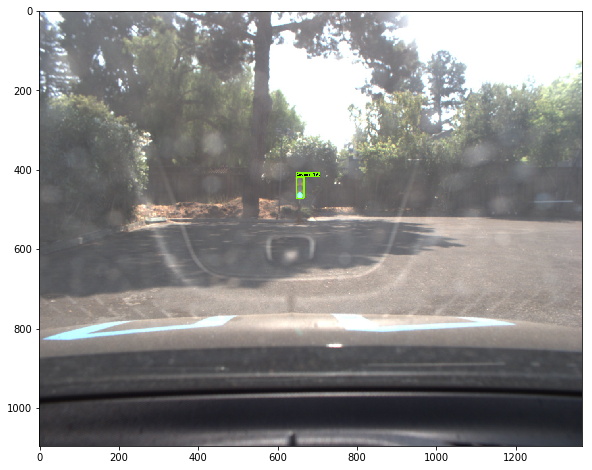

Green 0.9994437
ms 394.73938941955566 



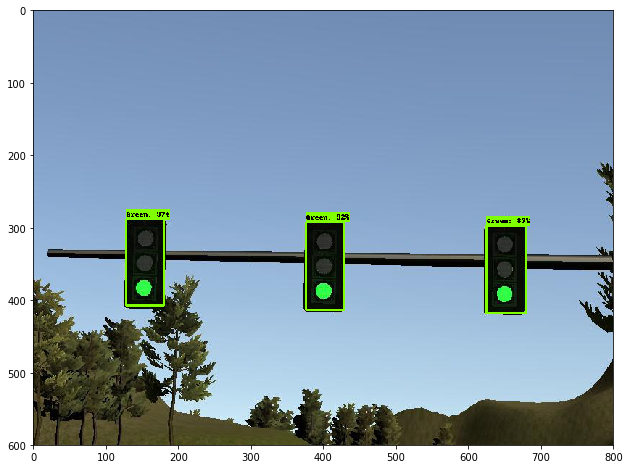

Green 0.9776759
ms 41.825056076049805 

Green 0.9209798
ms 41.825056076049805 

Green 0.8720406
ms 41.825056076049805 



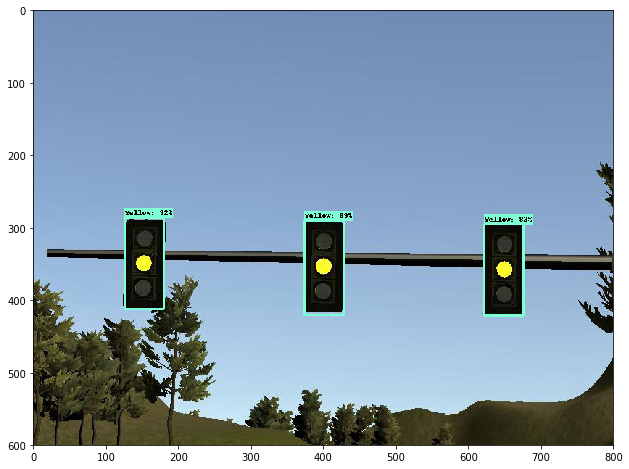

Yellow 0.92738324
ms 42.016029357910156 

Yellow 0.89260036
ms 42.016029357910156 

Yellow 0.8236528
ms 42.016029357910156 



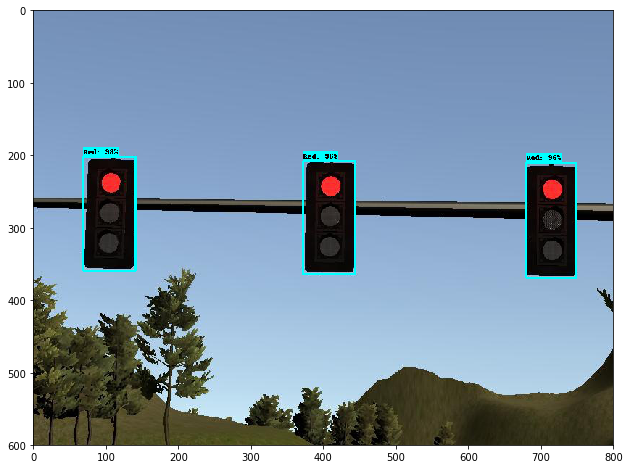

Red 0.9855552
ms 44.78025436401367 

Red 0.9698817
ms 44.78025436401367 

Red 0.96875095
ms 44.78025436401367 



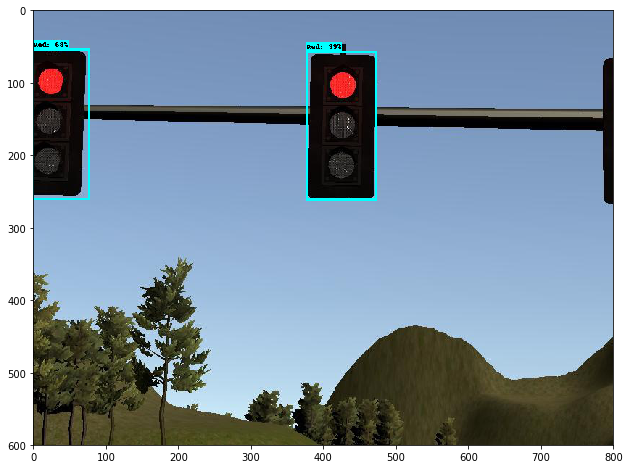

Red 0.997471
ms 49.896240234375 

Red 0.6886256
ms 49.896240234375 



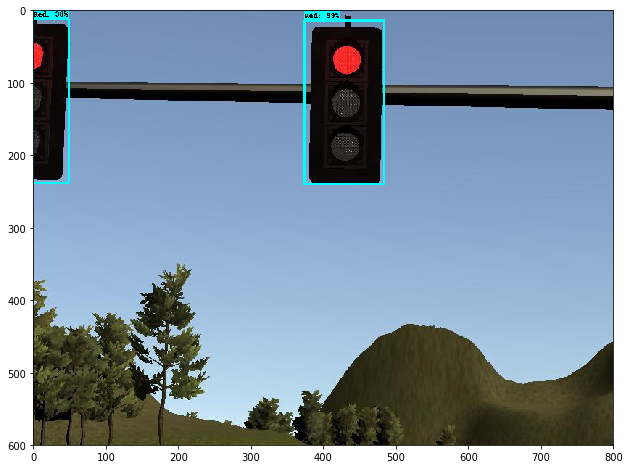

Red 0.9978818
ms 46.0810661315918 

Red 0.38744408
ms 46.0810661315918 



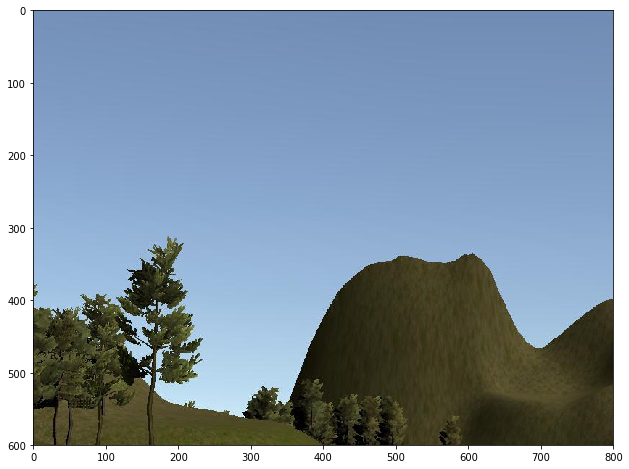

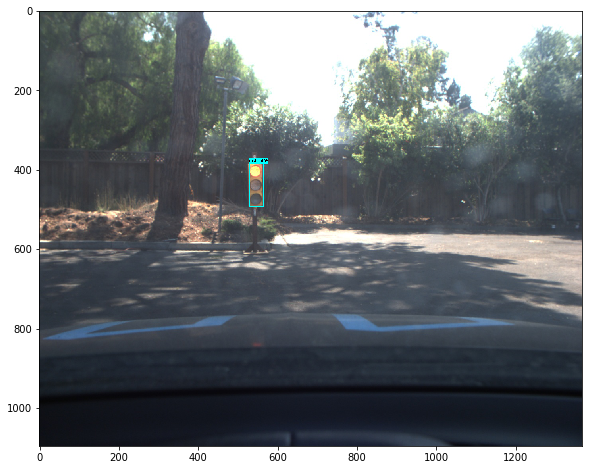

Red 0.99676126
ms 48.2630729675293 



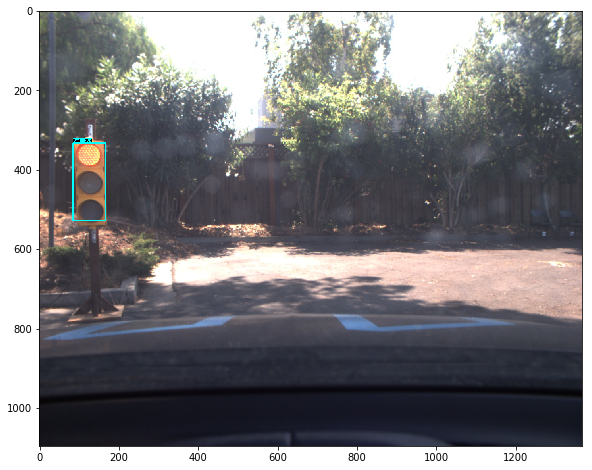

Red 0.9873574
ms 48.85745048522949 



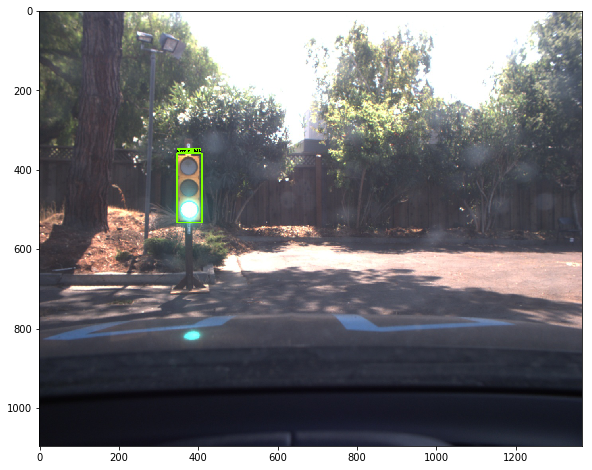

Green 0.99840933
ms 47.99699783325195 



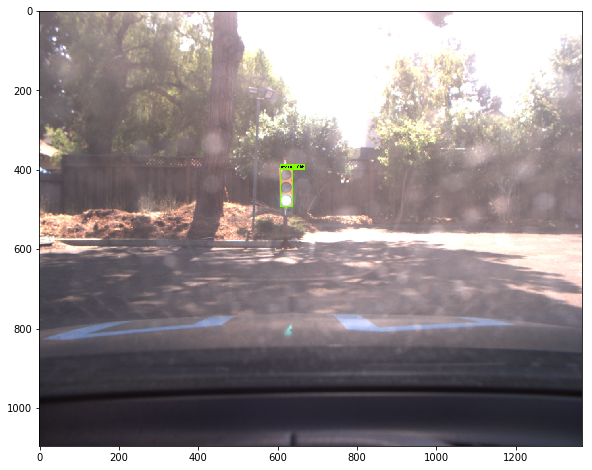

Green 0.9992048
ms 48.39515686035156 



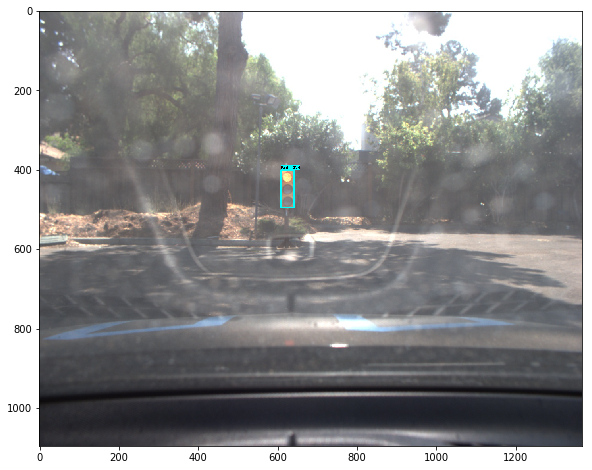

Red 0.9931377
ms 47.75691032409668 



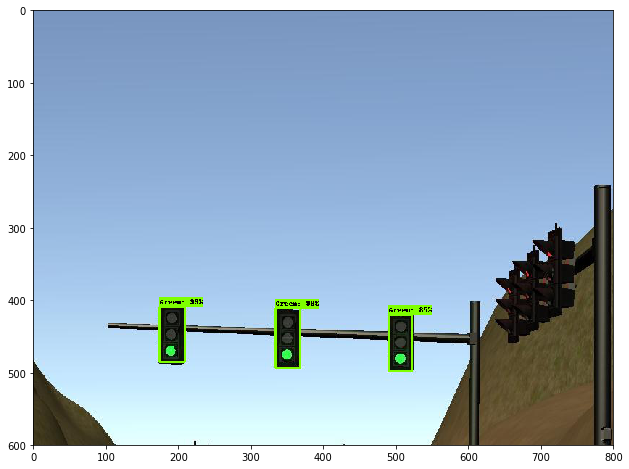

Green 0.999519
ms 61.65313720703125 

Green 0.99872726
ms 61.65313720703125 

Green 0.85893285
ms 61.65313720703125 



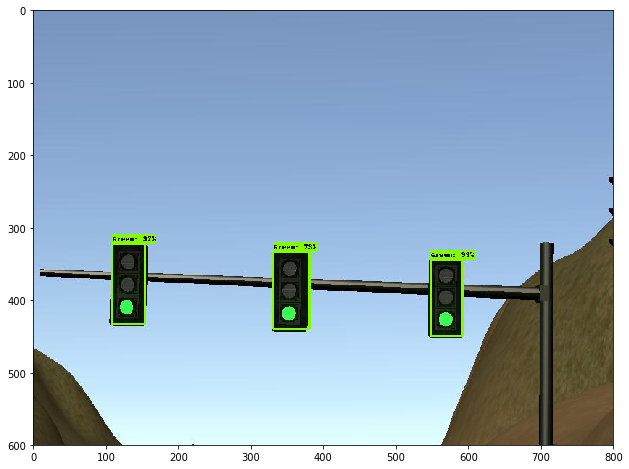

Green 0.99848455
ms 45.4716682434082 

Green 0.97040874
ms 45.4716682434082 

Green 0.7384363
ms 45.4716682434082 



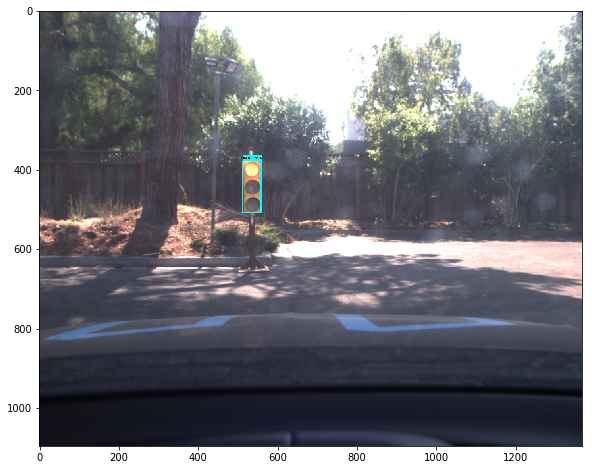

Red 0.9988701
ms 50.24003982543945 



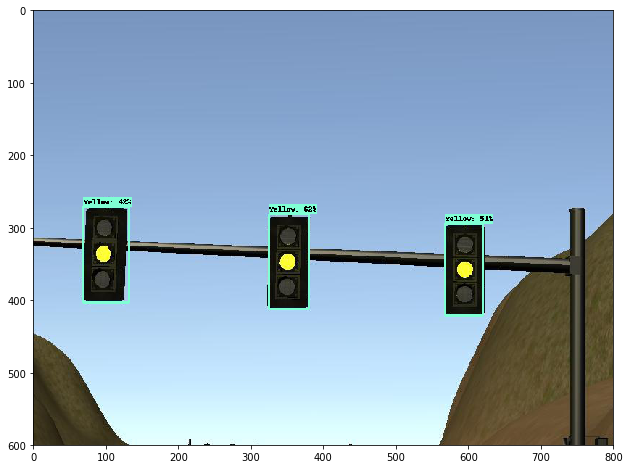

Yellow 0.6243181
ms 44.15702819824219 

Yellow 0.5110206
ms 44.15702819824219 

Yellow 0.4223804
ms 44.15702819824219 



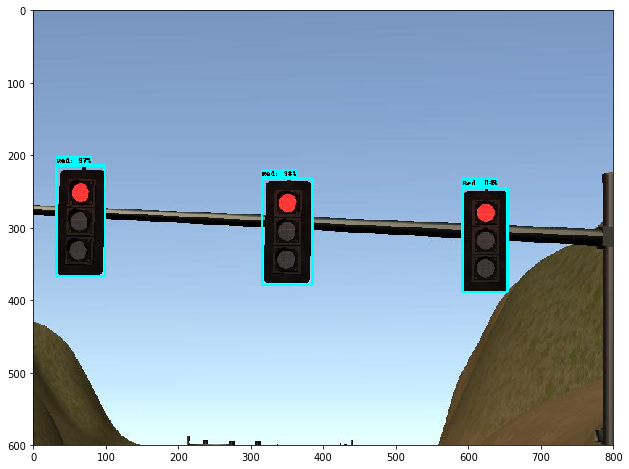

Red 0.98785806
ms 45.89581489562988 

Red 0.9738287
ms 45.89581489562988 

Red 0.84122986
ms 45.89581489562988 



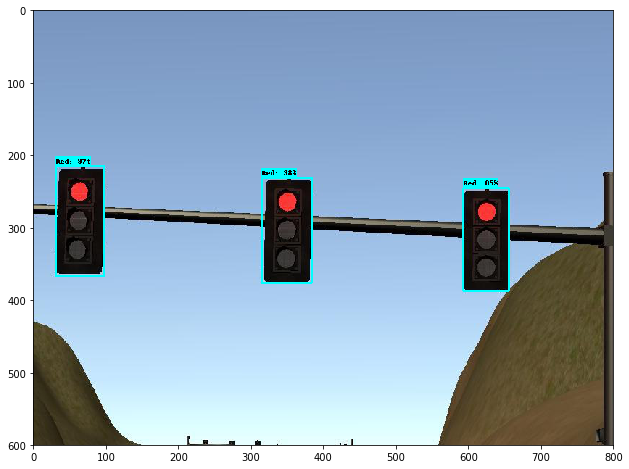

Red 0.9849578
ms 44.50035095214844 

Red 0.9703471
ms 44.50035095214844 

Red 0.8545712
ms 44.50035095214844 



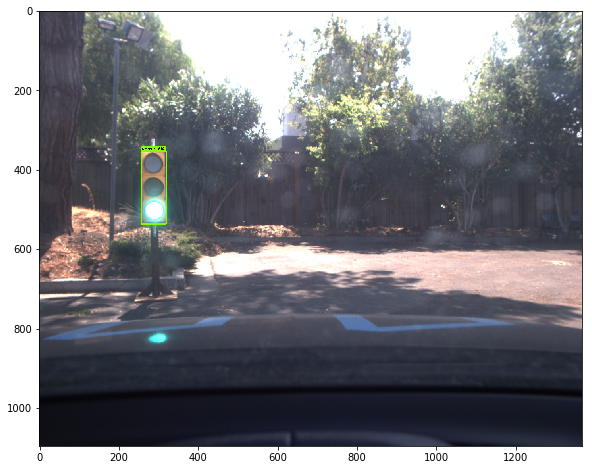

Green 0.69297844
ms 48.0349063873291 



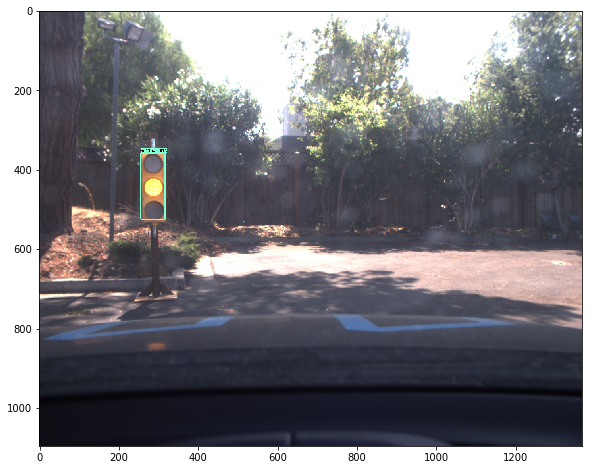

Yellow 0.87385994
ms 53.60531806945801 



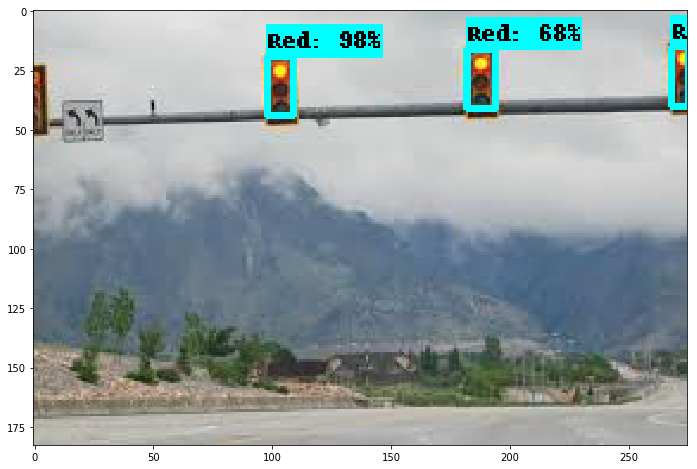

Red 0.9832064
ms 39.53886032104492 

Red 0.7259256
ms 39.53886032104492 

Red 0.68696
ms 39.53886032104492 



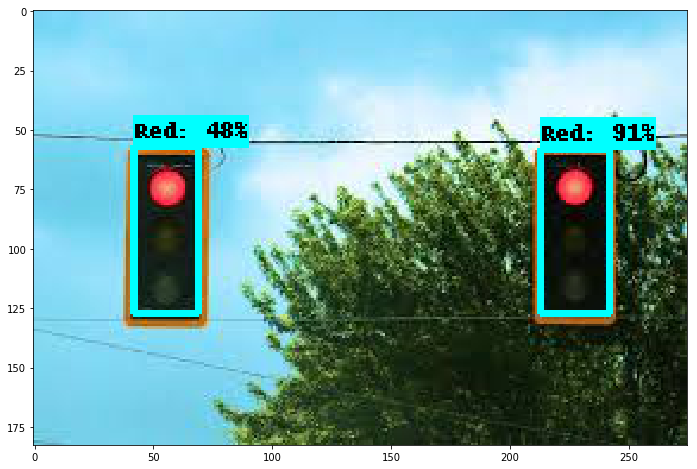

Red 0.91458833
ms 41.68391227722168 

Red 0.48378772
ms 41.68391227722168 



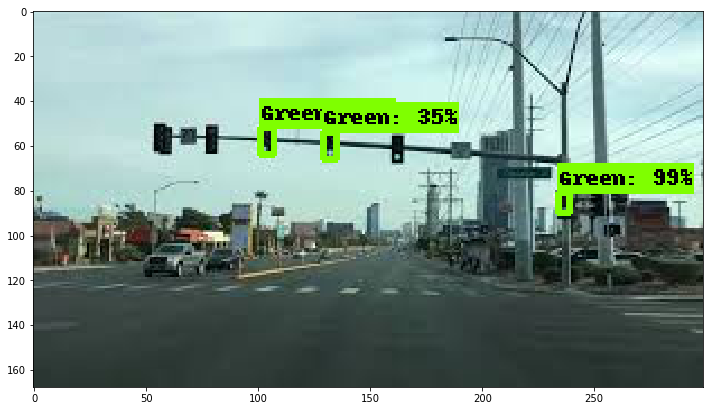

Green 0.99508554
ms 41.16463661193848 

Green 0.933845
ms 41.16463661193848 

Green 0.35329697
ms 41.16463661193848 



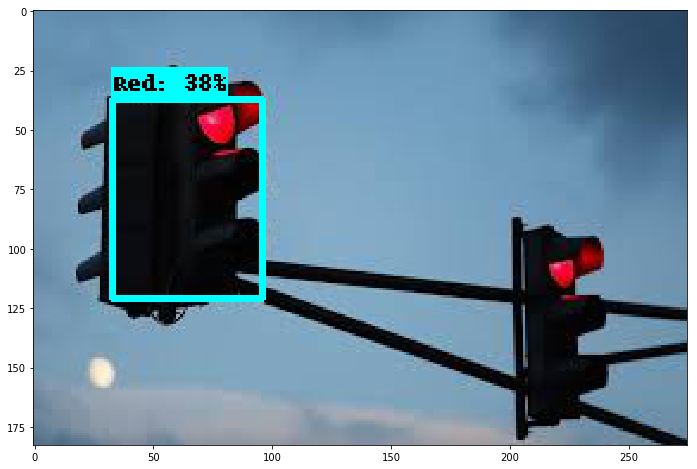

Red 0.38143054
ms 42.54317283630371 



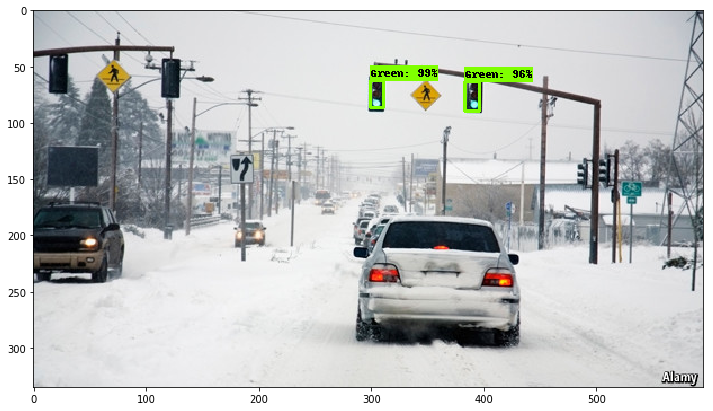

Green 0.9993585
ms 42.04297065734863 

Green 0.9666432
ms 42.04297065734863 



In [8]:
with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        # Definite input and output Tensors for detection_graph
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        
        # Each box represents a part of the image where a particular object was detected.
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        
        # Each score represent how level of confidence for each of the objects.
        # Score is shown on the result image, together with the class label.
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        
        def eval_an_image(image_path):
            image = Image.open(image_path)
            # the array based representation of the image will be used later in order to prepare the
            # result image with boxes and labels on it.
            image_np = load_image_into_numpy_array(image)
            # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
            image_np_expanded = np.expand_dims(image_np, axis=0)

            time0 = time.time()

            # Actual detection.
            ret = sess.run(
              [detection_boxes, detection_scores, detection_classes, num_detections],
              feed_dict={image_tensor: image_np_expanded})
            
            time1 = time.time()
            return ret, image_np, time1 - time0

        tot_time_elapsed = 0.
        for image_path in TEST_IMAGE_PATHS:
            (boxes, scores, classes, num), image_np, time_elapsed = eval_an_image(image_path)
            tot_time_elapsed += time_elapsed
            
            draw_a_detection_result(boxes, scores, classes, num, image_np, time_elapsed)   
            
            if not os.path.exists(EVAL_IMAGES_DIR):
                os.makedirs(EVAL_IMAGES_DIR)
                
            Image.fromarray(image_np).save(EVAL_IMAGES_DIR + '/' + os.path.basename(image_path))